In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as fn
from PIL import Image

In [2]:
import pydicom


(2708, 2847)
(1354, 2423)


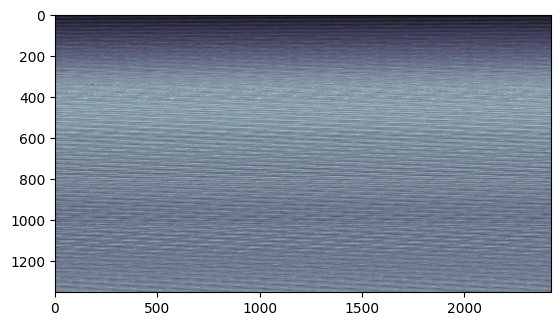

In [3]:
ds = pydicom.dcmread("/home/karan/Documents/GitHub/BTP/VinDr-CXR/0cbb68610a123b21defa9410699b0bb5.dicom")
img = ds.pixel_array
print(img.shape)
newimg = np.resize(img,(1354,2423))
print(newimg.shape)
plt.imshow(newimg, cmap=plt.cm.bone) 

In [4]:
import os

from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

/home/karan/miniconda3/envs/BTP_Proj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def read_xray(path, voi_lut = False, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [6]:
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    
    return im

In [7]:
image_id = []
dim0 = []
dim1 = []

for split in ['train']:
    load_dir = "/home/karan/Documents/GitHub/BTP/VinDr-CXR/"
    save_dir = f'/home/karan/Documents/kaggle/tmp/{split}/'

    os.makedirs(save_dir, exist_ok=True)

    for file in tqdm(os.listdir(load_dir)):
        # set keep_ratio=True to have original aspect ratio
        # try:
        xray = read_xray(load_dir + file)
        im = resize(xray, size=224)  
        im.save(save_dir + file.replace('dicom', 'png'))
        # except:
            # pass
        
        if split == 'train':
            image_id.append(file.replace('.dicom', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])

  1%|▏         | 13/1035 [00:04<06:55,  2.46it/s]/home/karan/miniconda3/envs/BTP_Proj/lib/python3.11/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
  1%|▏         | 14/1035 [00:06<11:32,  1.47it/s]/home/karan/miniconda3/envs/BTP_Proj/lib/python3.11/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
 70%|███████   | 728/1035 [07:42<03:14,  1.58it/s]


ValueError: The length of the pixel data in the dataset (1162786 bytes) doesn't match the expected length (13271040 bytes). The dataset may be corrupted or there may be an issue with the pixel data handler.

In [8]:
%%time
!tar -zcf train.tar.gz -C "/home/karan/Document/kaggle/tmp/train/" 
# !tar -zcf test.tar.gz -C "/kaggle/tmp/test/" 

tar: Cowardly refusing to create an empty archive
Try 'tar --help' or 'tar --usage' for more information.


CPU times: user 0 ns, sys: 9.99 ms, total: 9.99 ms
Wall time: 118 ms


In [9]:
df = pd.DataFrame.from_dict({'image_id': image_id, 'dim0': dim0, 'dim1': dim1})
df.to_csv('train_meta.csv', index=False)